In [1]:
from Function.Function import *
from os.path import abspath , join
from sklearn.preprocessing import normalize ,LabelEncoder,StandardScaler , Normalizer
from sklearn.decomposition import PCA 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from random import shuffle
import statsmodels.api as sm
import matplotlib.pyplot  as plt
current_folder =abspath('');current_folder



'/Users/yangtao/Documents/GitHub/850-project'

# Preprocessing data

In [2]:
# decide method of processing nan ( ignore nan, fill na with 0, fill na with mean)
methods = ['dropna' ,'fillna_0_after_normalization', 'fillna_0' ,'fillna_mean' ]
method = methods[0]
# decide method for normalization or standardlization
methods_n_s = ['normalization','standardlization']
methods_n_s = methods_n_s[0]
# cut tail
cut_tail = True
# effective test
Effective_test = True


In [3]:
P_calibrate = 0.8 #  datas for calibrate
# data = pd.read_csv('Data/finalproject_training.csv')
data = pd.read_csv('Data/finalproject_training_xy.csv')
print('--------\n','original data size is{}'.format(data.shape))

# the xs that was cleaned for useless price data and non number data and NONE data(first check)
# we also ignore the extrem value by exclude any value that beyond 0.95 % confidence level
data = data.loc[:,data.columns[12:]]
data = data.loc[:,(np.array(data.dtypes == 'int64') ) | (np.array(data.dtypes == 'float64') )]
# cut the tail to eliminate the fat tail effect
if cut_tail:
    data = cut_fat_tail(data,method)
    print('--------\n','we {} to mitigate the fat tail effect and cleaned data size is{}'.format('cut fat tail',data.shape))


--------
 original data size is(105337, 90)
--------
 we cut fat tail to mitigate the fat tail effect and cleaned data size is(88818, 72)


In [4]:
# process nan (fill na with 0, fill na with mean, ignore nan)

data,frac = process_nan(data , method);     print('--------\n','we use {} to clean nan and cleaned data size is{}'.format(method,data.shape))

# separate X and Y
X_data = data.iloc[:,:-1]
Y_data = data.iloc[:,-1]

#normalization or standardlization

if method == methods[1]:
    methods_n_s  = methods_n_s[0]
    print('--------\n','we use {} to process data'.format(methods_n_s))
else:
    print('--------\n','we use {} to process data'.format(methods_n_s))
    X_data = norml_standard(X_data , methods_n_s)
    
    
# effective test (T - test )
def effective_test (X , y):
    est = sm.OLS(y, X)
    est2 = est.fit()

    t_values = pd.DataFrame({'x' : X.columns, 't_value' :  est2.tvalues}).reset_index(drop= True)
    effective_factors = (t_values[(t_values.t_value < 1.96) & (t_values.t_value > -1.96)])
    effective_factors.insert(2 , 'abs',np.abs(effective_factors.t_value.values))
    effective_factors = effective_factors.sort_values(by = 'abs').reset_index(drop= True)
    return effective_factors
effective_test_result =  effective_test(X_data , Y_data)
X_data = X_data.loc[:,effective_test_result.x.values]
print('--------\n','we use T - test to exclude not effective factors') ; methods_n_s += '_after T-test'

(2290, 72)
--------
 we use dropna to clean nan and cleaned data size is(2290, 72)
--------
 we use normalization to process data
--------
 we use T - test to exclude not effective factors


In [5]:
# calibrate and validation
# sperate the data into calibration and validation. Also,batch shuffle the data to make more samples
X_data ,Y_data = get_data(X_data,Y_data,P_calibrate,batch = 5,frac = frac,shuffle = False)
print('--------\n','list of data included in the defaultdict' , list(X_data['calibrate'].keys()))
print('\n','each batch collection contain {} batches'.format(5))

--------
 list of data included in the defaultdict ['batch_without_shuffle', 'batch', 'origin']

 each batch collection contain 5 batches


# Autoencoder with nerual network 

# Construct model

In [6]:
dimension_of_input  = len(X_data['calibrate']['origin'].T) # number of stock
autoencoder = inital_model(dimension_of_input) # inital_model 
# train model
# we use net difference to train model
Autoencoder_data = np.array(X_data['calibrate']['origin']) 
# we use pre-trained model with best fit to save time
# if there is no pre_trained model, train one
try:
    path = join(current_folder,'Models/com_autoencoder_{}_{}.h5'.format(method , methods_n_s))
    autoencoder = load_model(path)
except:
    print('train model')
    autoencoder.fit(Autoencoder_data, Autoencoder_data, shuffle=False, epochs=200, batch_size = 100 , verbose = 1)
    autoencoder.save(join(current_folder,'Models/com_autoencoder_{}_{}.h5'.format(method , methods_n_s)))
    
# print('train model')
# autoencoder.fit(Autoencoder_data, Autoencoder_data, shuffle=False, epochs=200, batch_size = 10 , verbose = 1)
# autoencoder.save(join(current_folder,'Models/com_autoencoder_{}_{}.h5'.format(method , methods_n_s)))

# Predict and see what the factors is most relevent and explain most variance
# dimension reduction


In [7]:
path = join(current_folder,'Models/com_autoencoder_{}_{}.h5'.format(method , methods_n_s))
autoencoder = load_model(path)
predict = autoencoder.predict(Autoencoder_data) 
# use different error measure to decide which factors explain most variance

# we need to figure out what is the best error measure,?

# sum absolute relative error
diff = np.absolute(Autoencoder_data - predict)
communal_information = np.sum(diff -  diff.min()/(diff.max() - diff.min()),axis = 0) 
# ranking
ranking = np.array(communal_information).argsort()
ranks = pd.DataFrame({'communal' : communal_information[ranking] ,'index' : X_data['calibrate']['origin'].columns[ranking] })
ranks

,communal,index
0,0.000074,tfvceq
1,0.000162,epsf12
2,0.000311,ggroup
3,0.000948,gind
4,0.001413,epsfxq
5,0.006139,cshfdq
6,0.006262,cshfd12
7,0.006530,txpdy
8,0.006620,cshprq
9,0.009944,csh12q


### lower the communal_information,higer explaination

### you can do prediction by using autoencoder directly. i can write it down if we decide to do it

# Lets do PCA and backtest
### from here you either use pca classifier or linear regression for prediction


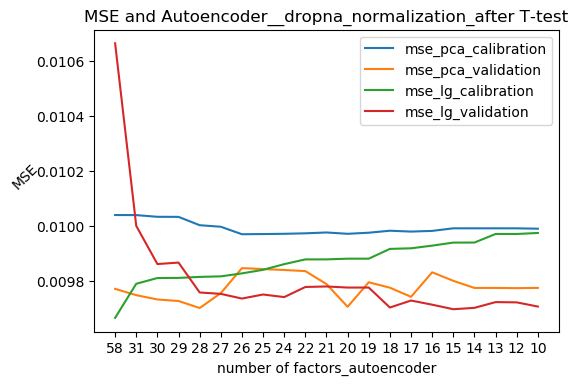

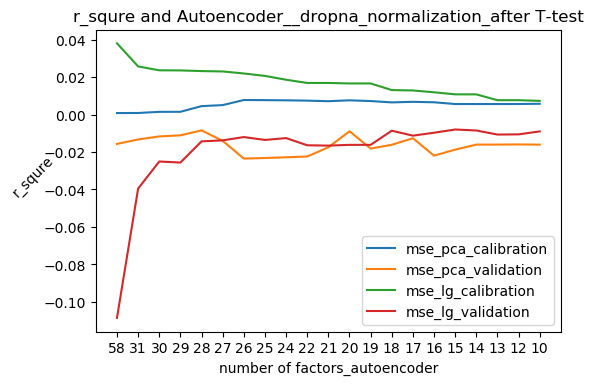

In [8]:
mse_df,r_squre_df,model_pca,model_lg = mse_compare(X_data['calibrate']['origin'] ,Y_data['calibrate']['origin'],\
                      X_data['validation']['origin'] ,Y_data['validation']['origin'] , ranking)

# plot mse
plt.figure(dpi = 100)
plt.plot(mse_df.reset_index().iloc[:,1:] )
plt.xticks(range(len(mse_df.index)),np.array(mse_df.index))
plt.legend(mse_df.columns)
plt.xlabel('number of factors_autoencoder')
plt.ylabel('MSE',rotation = 45)
plt.title('MSE and Autoencoder__{}_{}'.format(method , methods_n_s))
plt.show()


# plot r_squre
plt.figure(dpi = 100)
plt.plot(r_squre_df.reset_index().iloc[:,1:] )
plt.xticks(range(len(mse_df.index)),np.array(mse_df.index))
plt.legend(mse_df.columns)
plt.xlabel('number of factors_autoencoder')
plt.ylabel('r_squre',rotation = 45)
plt.title('r_squre and Autoencoder__{}_{}'.format(method , methods_n_s))
plt.show()

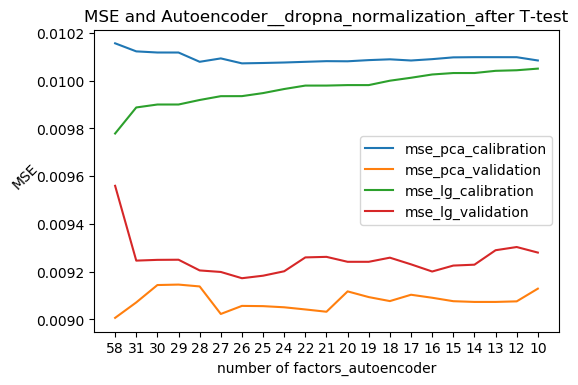

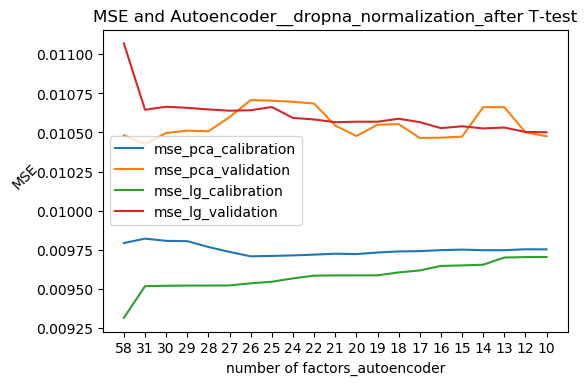

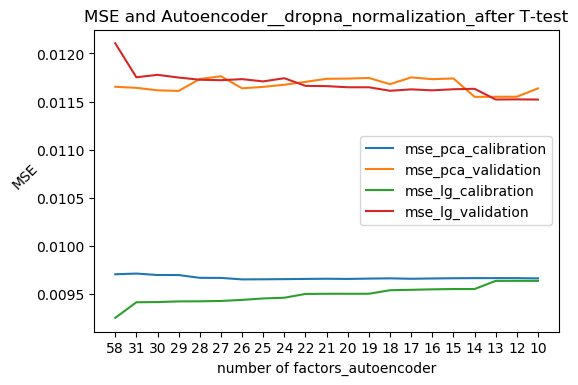

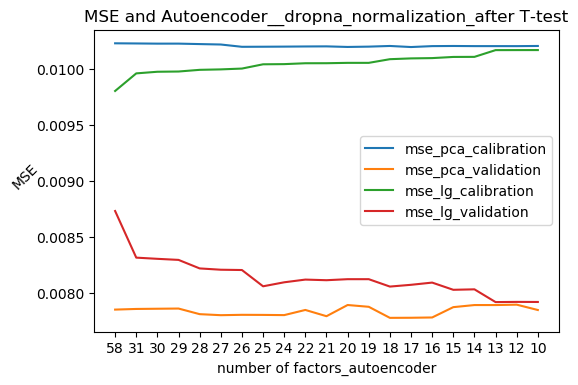

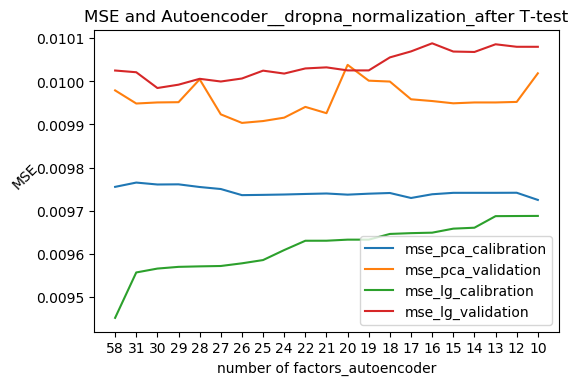

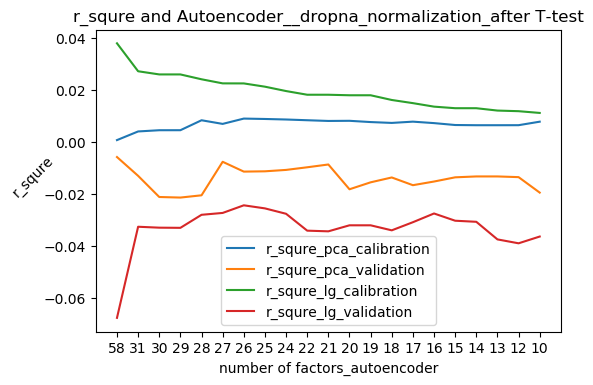

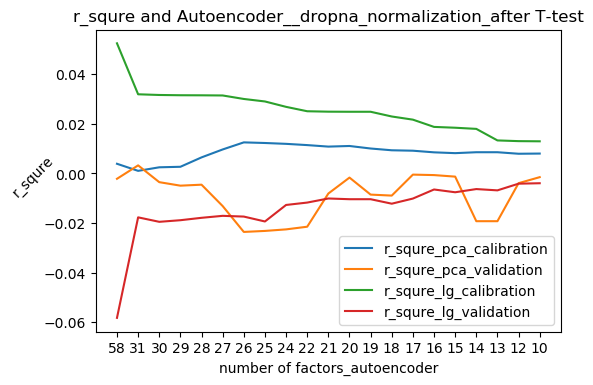

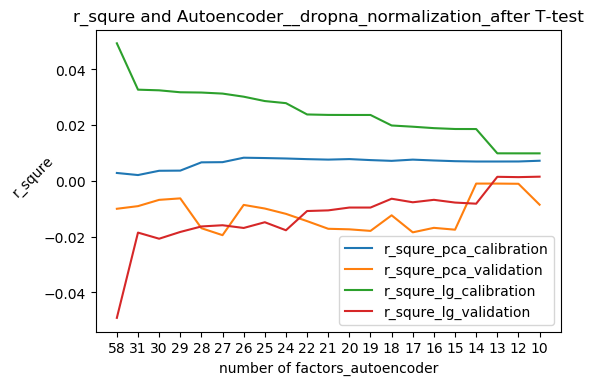

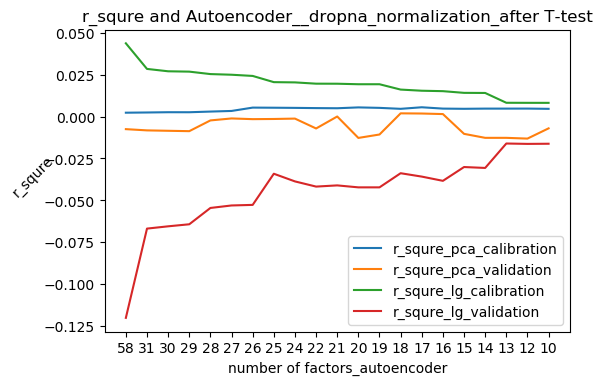

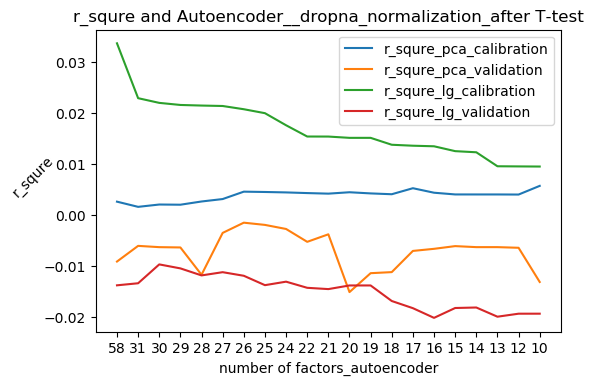

In [9]:
# batch with shuffle
mse_batch = []
r_squre_batch = []
batch_keys = [*X_data['calibrate']['batch'].keys()]
for i in range(len(batch_keys) ):
    result = mse_compare(X_data['calibrate']['batch'][batch_keys[i]] ,Y_data['calibrate']['batch'][batch_keys[i]],\
                      X_data['validation']['batch'][batch_keys[i]] ,Y_data['validation']['batch'][batch_keys[i]],ranking )
    mse_batch.append(result[0])
    r_squre_batch.append(result[1])
    
    
for i in mse_batch:
    plt.figure(dpi = 100)
    plt.plot(i.reset_index().iloc[:,1:] )
    plt.xticks(range(len(mse_df.index)),np.array(mse_df.index))
    plt.legend(i.columns)
    plt.xlabel('number of factors_autoencoder')
    plt.ylabel('MSE',rotation = 45)
    plt.title('MSE and Autoencoder__{}_{}'.format(method , methods_n_s))
    plt.show()
    
for i in r_squre_batch:
    plt.figure(dpi = 100)
    plt.plot(i.reset_index().iloc[:,1:] )
    plt.xticks(range(len(mse_df.index)),np.array(mse_df.index))
    plt.legend(i.columns)
    plt.xlabel('number of factors_autoencoder')
    plt.ylabel('r_squre',rotation = 45)
    plt.title('r_squre and Autoencoder__{}_{}'.format(method , methods_n_s))
    plt.show()

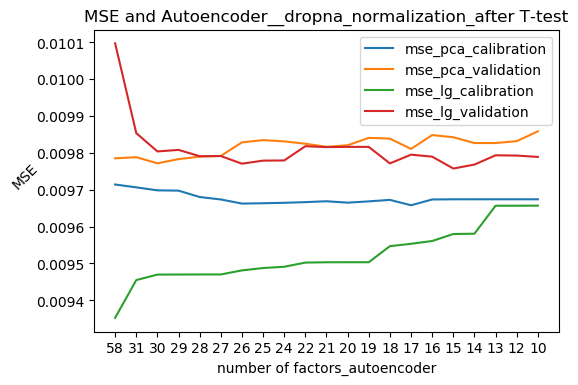

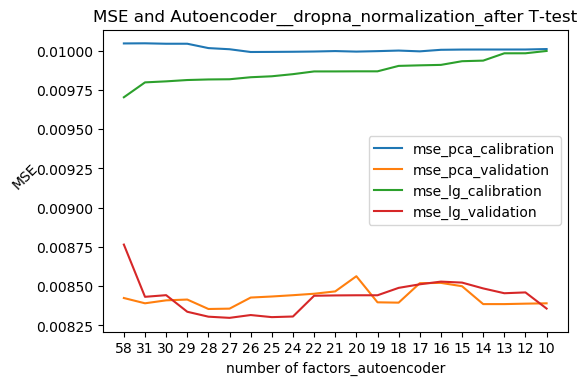

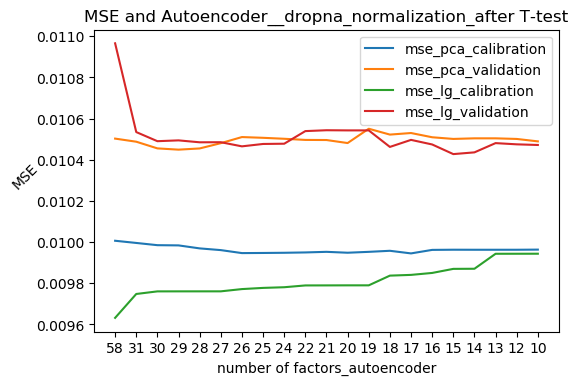

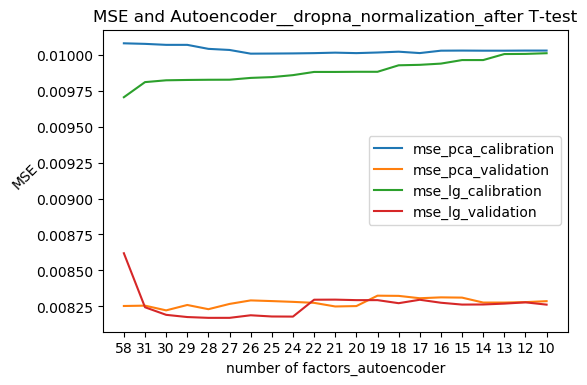

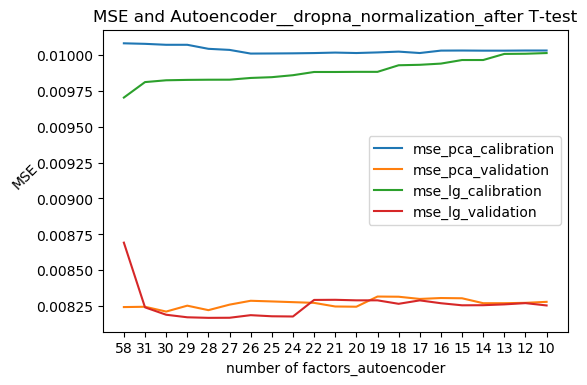

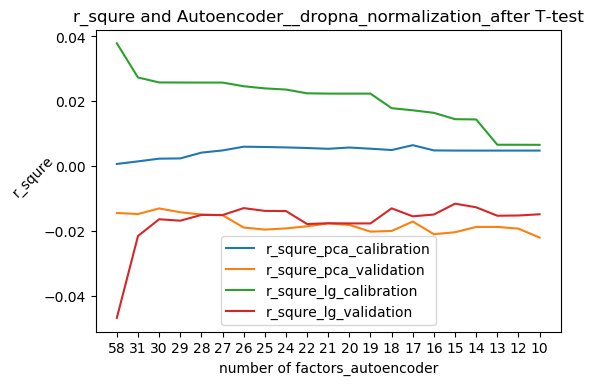

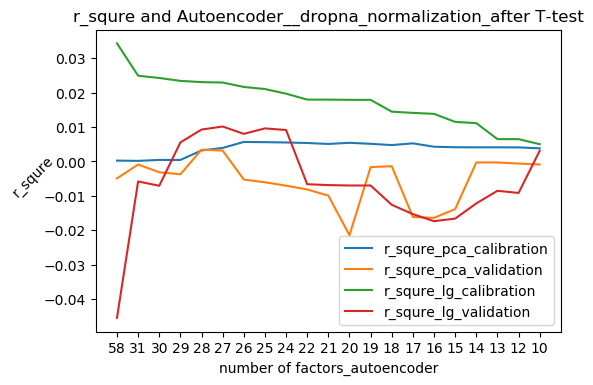

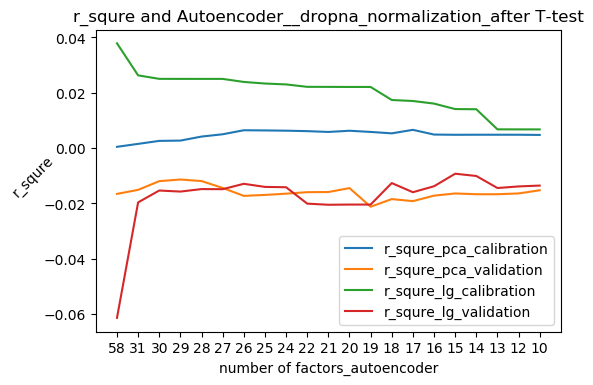

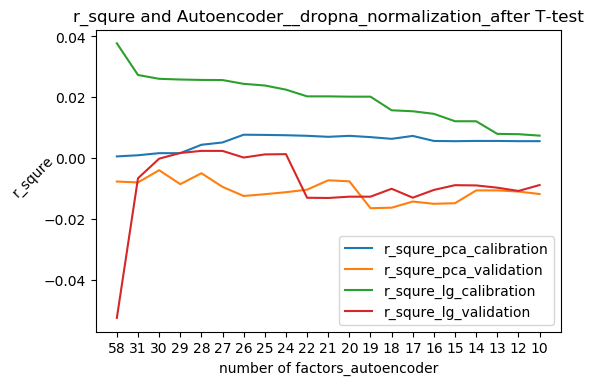

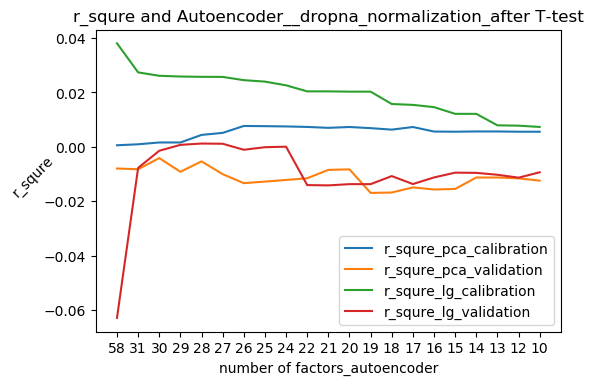

In [10]:
# batch without shuffle

mse_batch = []
r_squre_batch = []
batch_keys = [*X_data['calibrate']['batch_without_shuffle'].keys()]
for i in range(len(batch_keys) ):
    result = mse_compare(X_data['calibrate']['batch_without_shuffle'][batch_keys[i]] ,Y_data['calibrate']['batch_without_shuffle'][batch_keys[i]],\
                      X_data['validation']['batch_without_shuffle'][batch_keys[i]] ,Y_data['validation']['batch_without_shuffle'][batch_keys[i]],ranking )
    mse_batch.append(result[0])
    r_squre_batch.append(result[1])

for i in mse_batch:
    plt.figure(dpi = 100)
    plt.plot(i.reset_index().iloc[:,1:] )
    plt.xticks(range(len(mse_df.index)),np.array(mse_df.index))
    plt.legend(i.columns)
    plt.xlabel('number of factors_autoencoder')
    plt.ylabel('MSE',rotation = 45)
    plt.title('MSE and Autoencoder__{}_{}'.format(method , methods_n_s))
    plt.show()
    
for i in r_squre_batch:
    plt.figure(dpi = 100)
    plt.plot(i.reset_index().iloc[:,1:] )
    plt.xticks(range(len(mse_df.index)),np.array(mse_df.index))
    plt.legend(i.columns)
    plt.xlabel('number of factors_autoencoder')
    plt.ylabel('r_squre',rotation = 45)
    plt.title('r_squre and Autoencoder__{}_{}'.format(method , methods_n_s))
    plt.show()

In [11]:
accurcy_pca_calibrate = []
accurcy_pca_validation = []
accurcy_lg_calibrate = []
accurcy_lg_validation = []
accurcy_PCA_lg_calibrate = []
accurcy_PCA_lg_validation= []
n_factors = [*range(10,len(X_data['calibrate']['origin'].columns)//2 + 1, 2)] [::-1]
for k in n_factors:
    index = list(X_data['calibrate']['origin'].columns[ranking[:k]]) + \
             list(X_data['calibrate']['origin'].columns[ranking[-k:]])
    data = X_data['calibrate']['origin'].loc[:,index]
    rf = LogisticRegression()
    X = data
    y = Y_data['calibrate']['direction']
    pca = PCA(n_components=5) #initial model
    X_pca = pca.fit_transform(X) # pca decomposition

    rf.fit(X_pca,y)

    accurcy_pca_calibrate.append(rf.score(X_pca,y))
    # out of sample-validation
    # get validation X data and Y data
    X_test =  np.array(X_data['validation']['origin'].loc[:,index]) 
    X_test_pca = pca.fit_transform(X_test)
    y_test = Y_data['validation']['direction']

    accurcy_pca_validation.append(rf.score(X_test_pca,y_test))

    # using pca in LinearRegression
    pca = PCA(n_components=5) #initial model
    X_pca = pca.fit_transform(X) # pca decomposition
    model_pca = LinearRegression()# initial predicition model
    model_pca.fit(X_pca,y) # fit model

    # record accurcy
    accurcy_PCA_lg_calibrate.append(sum(np.array([-1 if i < 0 else 1 for i in model_pca.predict(X_pca)]) == y )/ len(y))
    # record accurcy
    accurcy_PCA_lg_validation.append(sum(np.array([-1 if i < 0 else 1 for i in model_pca.predict(X_test_pca)]) == y_test )/ len(y_test))


        
    model = LinearRegression()# initial predicition model
    model.fit(X,y)

    accurcy_lg_calibrate.append(sum(np.array([-1 if i < 0 else 1 for i in model.predict(X)]) == y )/ len(y))

    accurcy_lg_validation.append(sum(np.array([-1 if i < 0 else 1 for i in model.predict(X_test)])  == y_test )/ len(y_test))
accurcy= {'accurcy_pca_calibrate' : accurcy_pca_calibrate, 'accurcy_PCA_lg_calibrate': \
            accurcy_PCA_lg_calibrate,'accurcy_lg_calibrate' : accurcy_lg_calibrate, 'accurcy_pca_validation' : accurcy_pca_validation,'accurcy_PCA_lg_validation':accurcy_PCA_lg_validation,       'accurcy_lg_validation' : accurcy_lg_validation}
accurcy_dt = pd.DataFrame(accurcy , index = n_factors)    ;

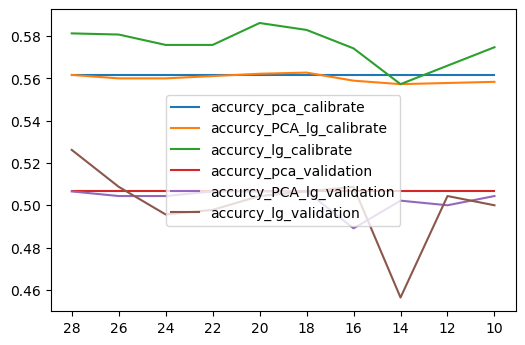

In [12]:
plt.figure(dpi =100)
plt.plot(accurcy_dt.reset_index().iloc[:,1:] )
plt.legend(accurcy_dt.columns)
plt.xticks(range(len(accurcy_dt.index)) , accurcy_dt.index)
plt.show()

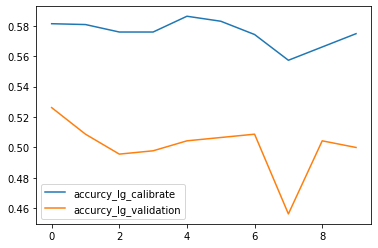

In [13]:
accurcy_dt.loc[:,['accurcy_lg_calibrate' , 'accurcy_lg_validation']].plot(use_index=False)

In [14]:
# k = 10
# n_components = range(1,k*2 -1,1)


# index = list(X_data['calibrate']['processed'].columns[ranking[:k]]) + \
#          list(X_data['calibrate']['processed'].columns[ranking[-k:]])
# data = X_data['calibrate']['processed'].loc[:,index]

# X_test =  np.array(X_data['validation']['processed'].loc[:,index]) 

# y_test = Y_data['validation']['direction']
# accurcy_pca_calibrate = []
# accurcy_pca_validation = []

# for s in n_components:
#     rf = RandomForestClassifier()
#     X = data
#     y = Y_data['calibrate']['direction']
#     pca = PCA(n_components=s) #initial model
#     X_pca = pca.fit_transform(X) # pca decomposition
#     X_test_pca = pca.fit_transform(X_test)
#     rf.fit(X_pca,y)

#     accurcy_pca_calibrate.append(rf.score(X_pca,y))
#     accurcy_pca_validation.append(rf.score(X_test_pca,y_test))


# plt.plot(accurcy_pca_validation)



# print(max(accurcy_pca_validation))
# print(accurcy_pca_validation.index(max(accurcy_pca_validation)))